# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
Контролировать добросовестность кассиров при продаже алкоголя.
Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
#Импортируем датасет с параметрами и папку с изображениями, разбиваем на пачки по 32 фотографии.
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


### Размер выборки

In [ ]:
labels.shape

(7591, 2)

### График распределения возраста в выборке

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f04f5bf2c10>]],
      dtype=object)

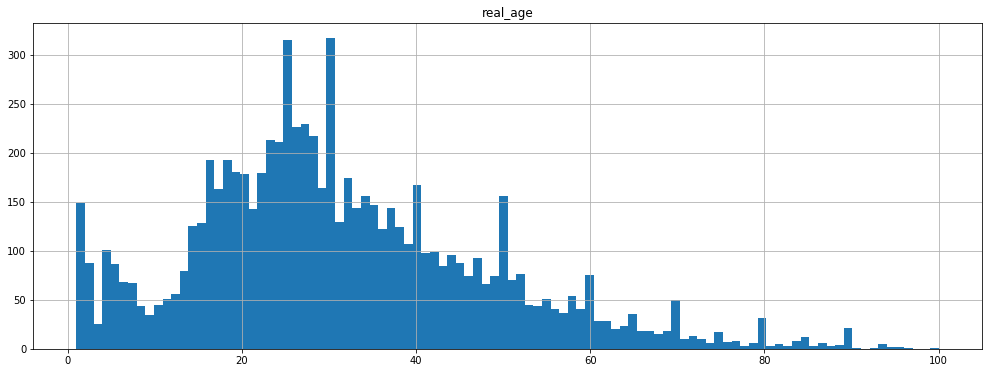

In [ ]:
labels.hist(bins=100, figsize = (17, 6))

<div class="alert alert-success">
<b>Комментарий ревьюера</b>

Отлично, что 100 корзин. Можно рассмотреть все особенности.
</div>

### Напечатайте на экране 10–15 фотографий

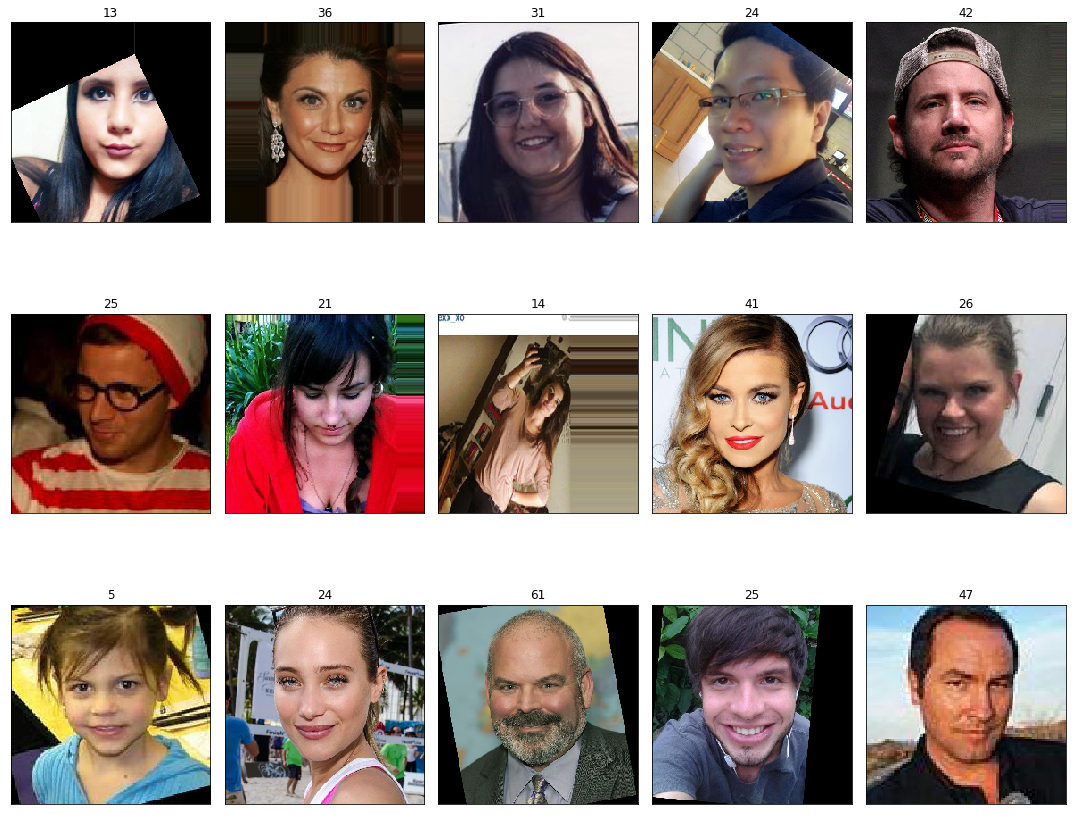

In [ ]:
features, target = next(train_gen_flow)
fig = plt.figure(figsize=(15,15))

for i in range(15):
    fig.add_subplot(3, 5, i+1)
    
    plt.imshow(features[i])
    
    plt.xticks([])
    plt.yticks([])
    plt.title(target[i])
    plt.tight_layout()
    

### Исследование расспределения датасета

In [ ]:
print(labels.describe())

          real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000


**Вывод**  
Размер выборки 7591 фотография.  

Распределение смещено влево, больше в датасете фотографий молодых людей до 41 года.  

Фотографии многие (но не все) выровнены по горизонтали. Есть фотографии в анфас, профиль, гримасы и частично закрытые лица.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import tensorflow as tf

```python
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow
```

In [ ]:
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

In [ ]:
def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])


    return model

In [ ]:
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

...  
Found 5694 validated image filenames.  
Found 1897 validated image filenames.  
...  
Train for 356 steps, validate for 119 steps  
Epoch 1/10  
356/356 - 120s - loss: 194.9656 - mae: 10.1472 - val_loss: 299.0431 - val_mae: 12.9475  
Epoch 2/10  
356/356 - 39s - loss: 85.4191 - mae: 7.0191 - val_loss: 155.5766 - val_mae: 9.2035  
Epoch 3/10  
356/356 - 39s - loss: 57.8417 - mae: 5.8071 - val_loss: 86.0703 - val_mae: 7.0344  
Epoch 4/10  
356/356 - 39s - loss: 43.4723 - mae: 5.0815 - val_loss: 103.1425 - val_mae: 7.5895  
Epoch 5/10  
356/356 - 39s - loss: 35.0643 - mae: 4.5209 - val_loss: 92.2945 - val_mae: 7.0574  
Epoch 6/10  
356/356 - 39s - loss: 24.8123 - mae: 3.8392 - val_loss: 72.7930 - val_mae: 6.2656  
Epoch 7/10  
356/356 - 39s - loss: 20.9645 - mae: 3.4781 - val_loss: 68.8412 - val_mae: 6.2819  
Epoch 8/10  
356/356 - 39s - loss: 16.7673 - mae: 3.1349 - val_loss: 77.6192 - val_mae: 6.7385  
Epoch 9/10  
356/356 - 39s - loss: 13.3624 - mae: 2.7671 - val_loss: 67.4542 - val_mae: 6.1027  
Epoch 10/10  
356/356 - 39s - loss: 13.0871 - mae: 2.7254 - val_loss: 66.5660 - val_mae: 6.1339  


119/119 - 9s - loss: 66.5660 - mae: 6.1339  
Test MAE: 6.1339  

**Вывод**  
Для постройки модели свёрточной нейронной сети была взята архитектура ResNet50.  
В отличие от других архитектур пройденных в цикле, эта справляется ощутимо быстро с лучшим качеством и без мучительного подбора параметров и сверточных слоев.
10 эпох хватило для достижения необходимого качества MAE < 8

## Анализ обученной модели

**Вывод**  
Полученная погрешность 6.1339 т.е. модель в среднем ошибается на 6 лет при определении возраста.  
Одонтологическая экспертиза в судебно-медицинской практике дает погрешность (8 лет у мужчин и 6 лет у женин), что говорит о неплохих результатах модели.  
Для бизнеса я думаю такая ошибка не критична. Так как бизнесу необходима чаще возрастная группа.  
Для научной цели наверно при большем датасете или аугментации можно было бы поднять качество.   
Но учитывая различную генетику и внешние факторы, МАЕ близкое к 0 точно будет говорить о переобучении.
